In [1]:
# System
import os
# Numpy
import numpy as np
# Dataframe
import pandas as pd
# Type hints
from typing import Union
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
# Datetime
import datetime as dt 
# Technical analysis tool
import talib
# Get market data
import pandas_datareader.data as web
# Statistics
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
# Base classes for estimators
from sklearn.base import (BaseEstimator, TransformerMixin,
                          ClassifierMixin, RegressorMixin)
# Cross-validation
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_validate
# Preprocessing
from sklearn.preprocessing import StandardScaler, QuantileTransformer, quantile_transform
from sklearn.decomposition import PCA
# Transformers
from sklearn.compose import make_column_transformer
# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline
# Feature selection
from sklearn.feature_selection import f_regression, SelectKBest
# Models
from sklearn.linear_model import Ridge
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor,
                              VotingRegressor, GradientBoostingRegressor)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
# Metrics
from sklearn.metrics import (make_scorer, 
            mean_squared_error, mean_absolute_error, r2_score)

# Get Data

In [2]:
# Seed
seed = 42

# set plots size
plt.rcParams['figure.figsize'] = (10, 4)

In [3]:
# Set date ranges:
## Start date
start = dt.datetime(2018,1,1)
## End date
end = dt.datetime(2020,9,1)

# Set symbol name
symbol_name = '^GSPC' #SP500

In [4]:
# Import data using Pandas Datareader
def get_data(symbol_name, start, end, data_source='yahoo'):
    df = web.DataReader(
            name = symbol_name, data_source = data_source, 
            start = start, end = end
        )
    return df

In [5]:
# Get data
df = get_data(symbol_name, start, end)

In [6]:
# Print prices of selected stock for start and end date
print(pd.concat([df.head(1), df.tail(1)]))

                   High          Low         Open        Close      Volume  \
Date                                                                         
2018-01-02  2695.889893  2682.360107  2683.729980  2695.810059  3367250000   
2020-09-01  3528.030029  3494.600098  3507.439941  3526.649902  4083110000   

              Adj Close  
Date                     
2018-01-02  2695.810059  
2020-09-01  3526.649902  


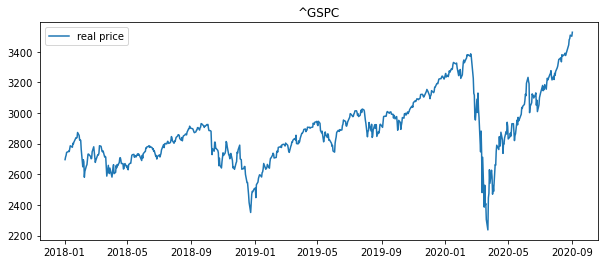

In [7]:
# Plot historical price data
plt.figure(figsize=(10,4))
plt.title(symbol_name)
plt.plot(df['Close'], label='real price')
plt.legend()
plt.show()

# Feature Engineering

### Percent Change 

In [8]:
class PercentChange(BaseEstimator, TransformerMixin):
    """Percent change of data.

    Attributes:
        column(str): Column name for calculation
        pct_periods(int): Periods to shift for forming percent change
    
    Methods:
        transform(X): Returns data percent change

    Returns:
        Dictionary.
    """
    def __init__(self, column: str, pct_periods: int):
        self.column = column
        self.pct_periods = pct_periods

    def fit( self, X: Union[pd.DataFrame, dict], y = None):
        return self        

    def transform(self, X: Union[pd.DataFrame, dict], y = None) -> dict:
        """Percent change.
        Arguments:
            X(pandas.dataframe,dict): df/dict with column(s) to calculate pct change.
        """
        features = {}
        features = X[self.column].pct_change(self.pct_periods)
        return features

### Difference of element

In [9]:
class DiffChange(BaseEstimator, TransformerMixin):
    """Calculates the difference of a Dataframe element.

    Attributes:
        colname(list/str): Column name for calculating difference
        diff_periods(int): Periods to shift for calculating difference, 
                            accepts negative values
    
    Methods:
        transform(X): Returns price change

    Returns:
        Dictionary/DataFrame.
    """
    def __init__(self, colname: str, diff_periods: int=1):
        self.colname = colname
        self.diff_periods = diff_periods

    def fit( self, X: Union[pd.DataFrame, dict], y = None):
        return self     

    def transform(self, X: Union[pd.DataFrame, dict], y = None) -> dict:
        """Calculates the difference of a Dataframe element.
        Arguments:
            X(pandas.dataframe,dict): df/dict with target columns
        """
        features = {}
        features = X[self.colname].diff(self.diff_periods)
        return features

### Daily Returns

In [10]:
class DailyReturn(BaseEstimator, TransformerMixin):
    """Daily return.
    
    Attributes:
        close(str): Column name for closing price.
        open(str): Column name for opening price.

    Methods:
        transform(X): Daily return

    Returns:
        Dictionary.
    """
    def __init__(self, close: str, open: str):
        self.close = close
        self.open = open

    def fit( self, X: Union[pd.DataFrame, dict], y = None):
        return self 

    def transform(self, X: Union[pd.DataFrame, dict], y = None) -> dict:
        """Daily return.
        Arguments:
            X(pandas.dataframe,dict): df/dict with daily return columns
        """
        features = {}
        features = X[self.close]/X[self.open]-1
        return features

### High-Low percent change

In [11]:
class HLpctChange(BaseEstimator, TransformerMixin):
    """High-low percent change.
    
    Attributes:
        high(str): Column name for highest price.
        low(str): Column name for lowest price.

    Methods:
        transform(X): Returns high-low percent change

    Returns:
        Dictionary.
    """
    def __init__(self, high: str, low: str):
        self.high = high
        self.low = low

    def fit( self, X: Union[pd.DataFrame, dict], y = None):
        return self 

    def transform(self, X: Union[pd.DataFrame, dict], y = None) -> dict:
        """High-low percent change.
        Arguments:
            X(pandas.dataframe,dict): df/dict with columns cointaining high & low prices.
        """
        features = {}
        features = X[self.high]/X[self.low]-1
        return features

### Stoch RSI

In [12]:
class StochRSI(BaseEstimator, TransformerMixin):
    """Stochastic Relative Strength Index (Momentum Indicators).
    
    Attributes:
        column(str): Column name taken for StochRSI calculations
        timeperiod(int): Periods taken to calculate Stoch RSI
        fastk_period(int): Number of past periods to use
        fastd_period(int): Number smoothing periods to apply to fastk

    Methods:
        transform(X): Returns StochRSI

    Returns:
        fastk & fastd.
    """
    def __init__(self, column: str, timeperiod: int,
                 fastk_period: int, fastd_period: int):
        self.column = column
        self.timeperiod = timeperiod
        self.fastk_period = fastk_period
        self.fastd_period = fastd_period

    def fit( self, X: Union[pd.DataFrame, dict], y = None):
        return self 

    def transform(self, X: Union[pd.DataFrame, dict], y = None) -> dict:
        """StochRSI.
        Arguments:
            X(pandas.dataframe,dict): df/dict with desired column for StochRSI
        """
        fastk, fastd = talib.STOCHRSI(
                        X[self.column],
                        timeperiod=self.timeperiod,
                        fastk_period=self.fastk_period, 
                        fastd_period=self.fastd_period
                    )
        return fastk, fastd

### SMA

In [13]:
class SMA(BaseEstimator, TransformerMixin):
    """SMA.
    
    Attributes:
        column(str): Column name
        timeperiod(int): Periods taken to calculate simple mean average
    
    Methods:
        transform(X): Returns SMA

    Returns:
        Dictionary.
    """
    def __init__(self, column: str, timeperiod: int):
        self.column = column
        self.timeperiod = timeperiod
    
    def fit( self, X: Union[pd.DataFrame, dict], y = None):
        return self 

    def transform(self, X: Union[pd.DataFrame, dict], y = None) -> dict:
        """SMA.
        Arguments:
            X(pandas.dataframe,dict): df/dict with desired column for SMA
        """
        features = {}
        features = talib.SMA(
                        X[self.column],
                        timeperiod=self.timeperiod
                    )
        return features

### Money Flow Index

In [14]:
class MFI(BaseEstimator, TransformerMixin):
    """Money Flow Index (MFI) for identifying overbought or oversold signals.
    
    Attributes:
        high(str): Column name for highest price.
        low(str): Column name for lowest price.
        close(str): Column name for closing price.
        volume(str): Column name for trading volume amount
        timeperiod(int): Periods taken to calculate MFI
    
    Methods:
        transform(X): Returns MFI

    Returns:
        Dictionary
    
    """
    def __init__(self, high: str, low: str, 
                 close: str, volume: str, timeperiod: int):
        self.high = high
        self.low = low
        self.close = close
        self.volume = volume
        self.timeperiod = timeperiod
    
    def fit( self, X: Union[pd.DataFrame, dict], y = None):
        return self 

    def transform(self, X: Union[pd.DataFrame, dict], y = None) -> dict:
        """Money Flow Index (MFI).
        Arguments:
            X(pandas.dataframe,dict): df/dict with desired columns for MFI
        """
        features = {}
        features = talib.MFI(
                        high=X[self.high],
                        low=X[self.low],
                        close=X[self.close],
                        volume=X[self.volume],
                        timeperiod=self.timeperiod
                    )
        return features

### OBV

In [15]:
class OBV(BaseEstimator, TransformerMixin):
    """On Balance Volume.

    Attributes:
        price(str): Column name of latest trading price
        volume(str): Column name of latest trading volume amount  

    Methods:
        transform(X): Returns OBV

    Returns:
        Dictionary.
    """
    def __init__(self, price: str, volume: str):
        self.price = price
        self.volume = volume
     
    def fit( self, X: Union[pd.DataFrame, dict], y = None):
        return self 

    def transform(self, X: Union[pd.DataFrame, dict], y = None) -> dict:
        """On Balance Volume.
        Arguments:
            X(pandas.dataframe,dict): df/dict with desired sum
        """
        features = {}
        features = talib.OBV(
                        X[self.price],
                        X[self.volume]
                    )
        return features

### Target

In [16]:
# Target
forecast_step = 1
target = df['Close'].shift(-forecast_step).pct_change()

### Generate features using previously created classes

In [17]:
# Create empty dict - for storing features
features = {}

# Percent Change 
features['f0'] = PercentChange('Close', 1).transform(df)
# Difference change
features['f1'] = DiffChange('Close', 1).transform(df)
# Daily Return
features['f2'] = DailyReturn(close='Close', open='Open').transform(df)
# High-Low percent change
features['f3'] = HLpctChange(high='High', low='Low').transform(df)
# Stoch RSI
features['f4'], features['f5'] =\
    StochRSI(column='Close', timeperiod=14, 
            fastk_period=5, fastd_period=3).transform(df)
# SMA
features['f6'] = SMA(column='Close', timeperiod=7).transform(df)
features['f7'] = SMA(column='Close', timeperiod=14).transform(df)
features['f8'] = SMA(column='Close', timeperiod=21).transform(df)
# Money Flow Index
features['f9'] = MFI(high='High', low='Low', close='Close', 
                    volume='Volume', timeperiod=14).transform(df)
# OBV
features['f10'] = OBV(price='Close', volume='Volume').transform(df)
## Signing (-1,1)
features['f11'] = PercentChange('Close', 1).transform(df).apply(np.sign)
## Count bear|bull candles
features['f12'] = features['f11'].rolling(5).sum()

In [18]:
# Convert features dictionary to pandas dataframe
features = pd.DataFrame(features)
print(features.head())

                  f0         f1        f2        f3  f4  f5  f6  f7  f8  f9  \
Date                                                                          
2018-01-02       NaN        NaN  0.004501  0.005044 NaN NaN NaN NaN NaN NaN   
2018-01-03  0.006399  17.250000  0.005638  0.006153 NaN NaN NaN NaN NaN NaN   
2018-01-04  0.004029  10.929932  0.001721  0.003759 NaN NaN NaN NaN NaN NaN   
2018-01-05  0.007034  19.159912  0.004327  0.005693 NaN NaN NaN NaN NaN NaN   
2018-01-08  0.001662   4.560059  0.001838  0.003985 NaN NaN NaN NaN NaN NaN   

                     f10  f11  f12  
Date                                
2018-01-02  3.367250e+09  NaN  NaN  
2018-01-03  6.905910e+09  1.0  NaN  
2018-01-04  1.060117e+10  1.0  NaN  
2018-01-05  1.383779e+10  1.0  NaN  
2018-01-08  1.708044e+10  1.0  NaN  


### Example: plot SMA & RSI

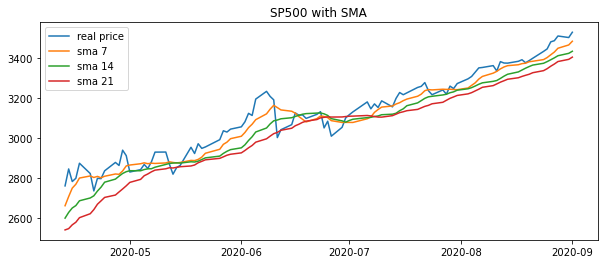

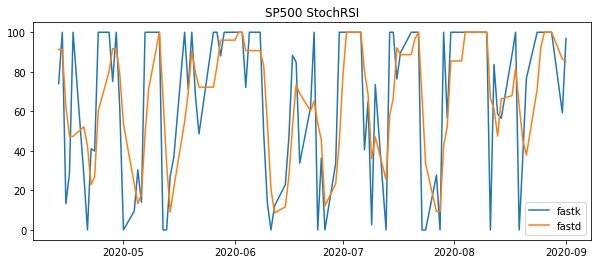

In [19]:
# Plot SMA
plt.plot(df['Close'][-100:], label='real price')
plt.plot(features['f6'][-100:], label='sma 7')
plt.plot(features['f7'][-100:], label='sma 14')
plt.plot(features['f8'][-100:], label='sma 21')
plt.title('SP500 with SMA')
plt.legend()
plt.show()
# Plot RSI
plt.plot(features['f4'][-100:], label='fastk')
plt.plot(features['f5'][-100:], label='fastd')
plt.title('SP500 StochRSI')
plt.legend()
plt.show()

# Fit & Predict

In [20]:
# Create X and y 
X = features.dropna()
y = target[X.index]
print(X.head())
print(y.head())

                  f0          f1        f2        f3         f4        f5  \
Date                                                                        
2018-01-31  0.000489    1.380127 -0.003036  0.009321   1.005745  0.335248   
2018-02-01 -0.000648   -1.830078  0.001963  0.008270   0.000000  0.335248   
2018-02-02 -0.021209  -59.850098 -0.016658  0.017736   0.000000  0.335248   
2018-02-05 -0.040979 -113.189941 -0.033607  0.047465   0.000000  0.000000   
2018-02-06  0.017441   46.199951  0.030733  0.041638  24.388117  8.129372   

                     f6           f7           f8         f9           f10  \
Date                                                                         
2018-01-31  2841.222866  2818.760010  2789.803816  77.432970  3.053544e+10   
2018-02-01  2838.772879  2822.647147  2795.811907  70.162348  2.659699e+10   
2018-02-02  2828.000000  2820.924997  2798.148565  62.681037  2.229586e+10   
2018-02-05  2800.812849  2811.819284  2794.574754  53.979954  1.701240

In [21]:
# Train test split
def train_test_split(X, y, size):
    X_train = X[:int(X.shape[0]*size)]
    X_test = X[int(X.shape[0]*size):]
    y_train = y[:int(y.shape[0]*size)]
    y_test = y[int(y.shape[0]*size):]
    return X_train, X_test, y_train, y_test

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, size=0.9)
print(f'Train: {len(X_train)}, Test: {len(X_test)}')

Train: 586, Test: 66


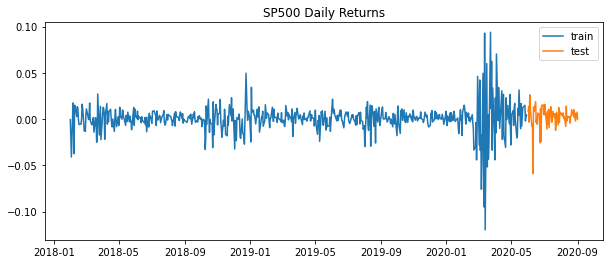

In [23]:
# Plot train & test datasets
plt.plot(y_train, label='train')
plt.plot(y_test, label='test')
plt.title('SP500 Daily Returns')
plt.legend()
plt.show()

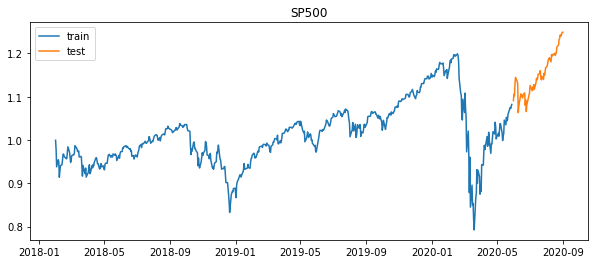

In [24]:
# Plot percent change
y_all = pd.concat([y_train, y_test])+1
y_all = y_all.cumprod()
plt.plot(y_all[:len(y_train)], label='train')
plt.plot(y_all[len(y_train):], label='test')
plt.title('SP500')
plt.legend()
plt.show()

&lt;AxesSubplot:title={&#39;center&#39;:&#39;Strength of correlation (features) to target&#39;}&gt;

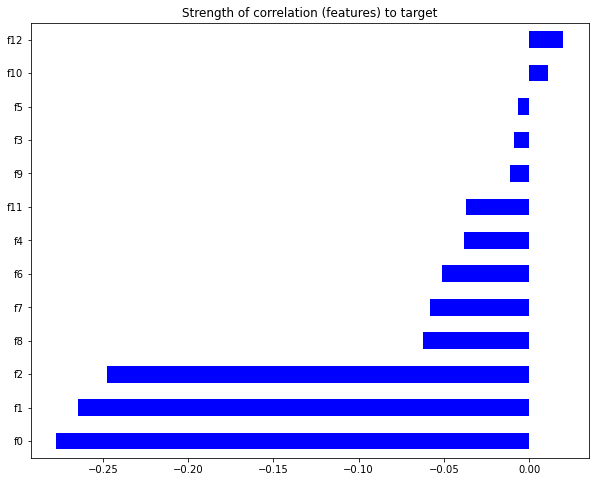

In [25]:
# Check correlation between features and target
_y = target #df['Close']
corr = features.corrwith(_y)
plt.figure(figsize=(10,8))
corr.sort_values().plot.barh(color='blue', 
    title='Strength of correlation (features) to target')

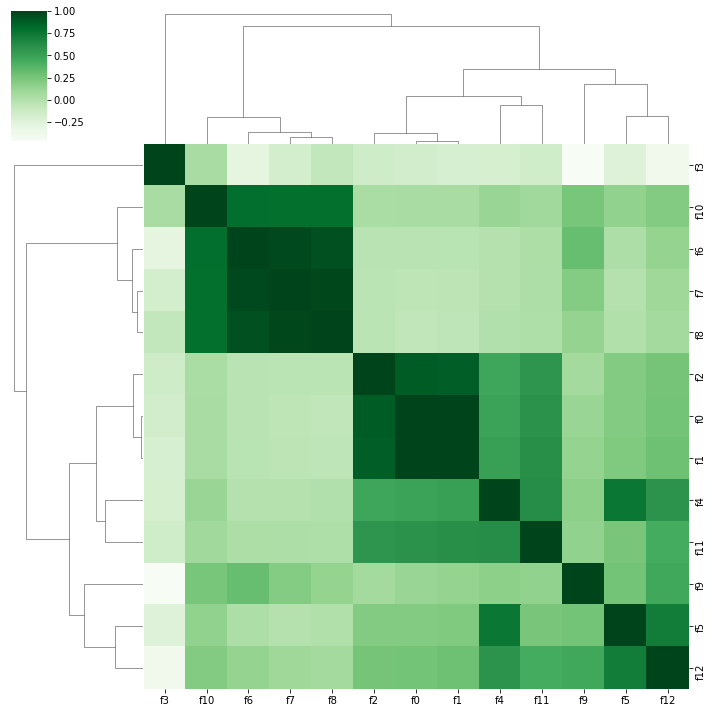

In [26]:
# Check correlation between features themselves
from scipy.cluster import hierarchy
from scipy.spatial import distance
corr_matrix = features.corr()
correlations_array = np.asarray(corr_matrix)
linkage = hierarchy.linkage(distance.pdist(correlations_array), method='average')
g = sns.clustermap(corr_matrix, row_linkage=linkage, col_linkage=linkage, 
                   row_cluster=True, col_cluster=True, 
                   figsize=(10,10), cmap='Greens')

# Out-of-Sample Forecast

In [27]:
# Time series split
tscv = TimeSeriesSplit(n_splits=3)

# Pipeline
pipe_0 = Pipeline([
    ('scaler', 'passthrough'),
    ('decomposer', 'passthrough'),
    ('regressor', 'passthrough')
])

# Estimators for VotingRegressor
reg1 = GradientBoostingRegressor()
reg2 = RandomForestRegressor()
reg3 = Ridge()

param_grid = {
    'scaler': [StandardScaler(), QuantileTransformer()],
    'decomposer': ['passthrough', PCA(0.95), PCA(0.90)],
    'regressor': [Ridge(), RandomForestRegressor(), ExtraTreesRegressor(), 
                  VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)]), 
                  SVR(), KNeighborsRegressor(),
                  xgb.XGBRegressor(objective='reg:squarederror')],
}

In [28]:
# Create scoring for models
# R2
R2_score = make_scorer(r2_score, greater_is_better=True)
# MAE
mae_score = make_scorer(mean_absolute_error, greater_is_better=False)
# RMSE
rmse_score = make_scorer(mean_squared_error, greater_is_better=False)
# All scores together
scoring={
    "R2": R2_score,
    "mae": mae_score,
    'rmse': rmse_score
}

In [29]:
# Run GridSearchCV
search = GridSearchCV(
            estimator=pipe_0, 
            param_grid=param_grid, 
            scoring=scoring, 
            refit="R2",
            n_jobs=-1,
            cv=tscv)

# Fit model
model_fit = search.fit(X_train, y_train)

# Print best parameters
print(f'Best model parameters:\n{model_fit.best_params_}')

Best model parameters:
{&#39;decomposer&#39;: PCA(n_components=0.95), &#39;regressor&#39;: RandomForestRegressor(), &#39;scaler&#39;: StandardScaler()}


In [30]:
# Pedict daily returns
y_pred = model_fit.predict(X_test)
y_pred = pd.DataFrame(y_pred, index=y_test.index)
# Compare predictions with real values
y_join = pd.concat([y_test, y_pred], axis=1)
y_join.columns = ['real', 'predicted']
y_join['Error [%]'] = (y_join['predicted']-y_join['real']).cumsum().round(3)

print(f'''Daily returns\n{y_join*100}
\nError statistics:
{(y_join['Error [%]']*100).describe().round(1)}''')

Daily returns
                real  predicted  Error [%]
Date                                      
2020-06-01  0.821083   0.402679       -0.4
2020-06-02  1.364898   0.125578       -1.7
2020-06-03 -0.336870  -0.016757       -1.3
2020-06-04  2.621165  -0.082919       -4.0
2020-06-05  1.204158  -0.734556       -6.0
...              ...        ...        ...
2020-08-26  0.167304  -0.660259      -12.5
2020-08-27  0.673257  -0.151269      -13.3
2020-08-28 -0.219496  -0.193184      -13.3
2020-08-31  0.752500  -1.032275      -15.1
2020-09-01  0.000000  -0.477149      -15.6

[66 rows x 3 columns]

Error statistics:
count    66.0
mean     -1.2
std       5.4
min     -15.6
25%      -4.1
50%       0.8
75%       2.6
max       6.7
Name: Error [%], dtype: float64


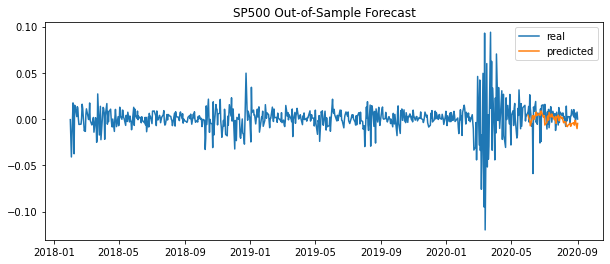

R2=-0.3


In [31]:
# Plot percent change
plt.plot(y, label='real')
plt.plot(y_pred, label='predicted')
plt.title('SP500 Out-of-Sample Forecast')
plt.legend()
plt.show()
# Calculate r2 of predicted daily returns
print(f'R2={round(r2_score(y_test, y_pred), 2)}')

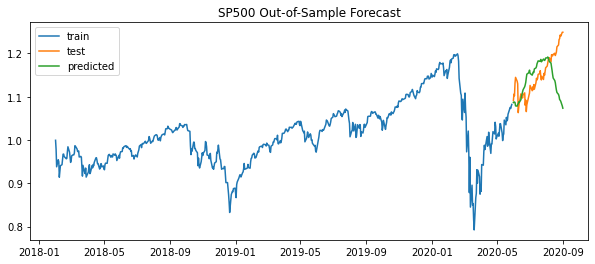

In [32]:
# Plot price forecast
y_all = pd.concat([y_train, y_test])+1
y_all = y_all.cumprod()
y_all_pred = pd.concat([y_train, y_pred])+1
y_all_pred = y_all_pred.cumprod()
plt.plot(y_all[:len(y_train)], label='train')
plt.plot(y_all[len(y_train):], label='test')
plt.plot(y_all_pred[len(y_train):], label='predicted')
plt.title('SP500 Out-of-Sample Forecast')
plt.legend()
plt.show()

# Walk Forward Testing / Rolling Window Forecast

In [33]:
# Set window size
window = 100
#initialize the CV with this window size
n_splits = len(X)-window
tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=window)

In [34]:
# Print first 10 cv splits
i=0
for train_index, test_index in tscv.split(X):
    if i <10:
        print("TRAIN:", train_index, "TEST:", test_index)
        i+=1

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99] TEST: [100]
TRAIN: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100] TEST: [101]
TRAIN: [  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  6

In [35]:
# Pipeline
pipe_1 = Pipeline([
    ('scaler', StandardScaler()),
    ('decomposer', PCA(n_components=0.95)),
    ('regressor', RandomForestRegressor())
])

# Create scorer to collect Walk Forward predictions
preds = []
def collect_preds(y, y_pred):
    return y_pred

collect_score = make_scorer(collect_preds, greater_is_better=False)

# All scores together
scoring={
    'R2': R2_score,
    'mae': mae_score,
    'rmse': rmse_score,
    'collect': collect_score,
}

In [36]:
# Run GridSearchCV
walk_forward = cross_validate(
            estimator=pipe_1,
            X=X,
            y=y,
            scoring=scoring, 
            n_jobs=-1,
            cv=tscv
        )

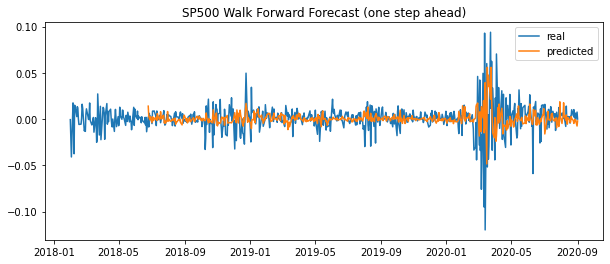

R2=-0.37


In [37]:
# Plot
y_pred = pd.DataFrame(walk_forward['test_collect'])
y_pred.index = y[window:].index
# Plot percent change
plt.plot(y, label='real')
plt.plot(y_pred, label='predicted')
plt.title('SP500 Walk Forward Forecast (one step ahead)')
plt.legend()
plt.show()

# Calculate r2 of predicted daily returns
print(f'R2={round(r2_score(y[window:], y_pred), 2)}')

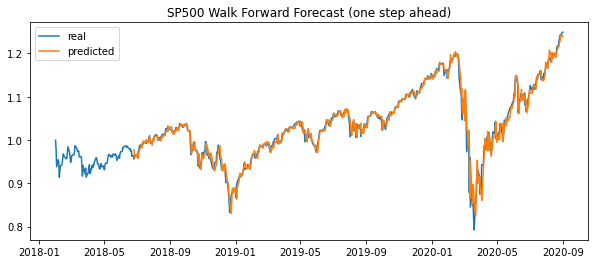

R2=0.96


In [38]:
y_true_price = (y+1).cumprod()
y_con = pd.concat([y_true_price[y_pred.index], y_pred], axis=1)
y_con.columns = ['true', 'pred']
y_pred_price = y_con['true']*y_con['pred']+y_con['true']
y_pred_price = y_pred_price.shift(1)

# Plot price forecast
plt.plot(y_true_price, label='real')
plt.plot(y_pred_price, label='predicted')
plt.title('SP500 Walk Forward Forecast (one step ahead)')
plt.legend()
plt.show()

print(f'R2={round(r2_score(y_true_price[y_pred_price.index][1:], y_pred_price[1:]), 2)}')


## Here we see that the outstanding results i.e. R2=0.96, for stock price prediction are obviously falsified. 
## That's the reason why we should use daily returns or other stationary data to compare results.